In [1]:
import os, cPickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.io import loadmat

from sklearn.decomposition import PCA

from palettable.colorbrewer.qualitative import Set1_9
colors = Set1_9.mpl_colors
cmap = Set1_9.mpl_colormap

%matplotlib inline

In [2]:
data_dir = "whole brain data Kato et al 2015"
zimmer_state_labels = \
    loadmat(os.path.join(
            data_dir, 
            "sevenStateColoring.mat"))
    
worm_files = ["TS20140715e_lite-1_punc-31_NLS3_2eggs_56um_1mMTet_basal_1080s.mat",
              "TS20140715f_lite-1_punc-31_NLS3_3eggs_56um_1mMTet_basal_1080s.mat",
              "TS20140905c_lite-1_punc-31_NLS3_AVHJ_0eggs_1mMTet_basal_1080s.mat",
              "TS20140926d_lite-1_punc-31_NLS3_RIV_2eggs_1mMTet_basal_1080s.mat",
              "TS20141221b_THK178_lite-1_punc-31_NLS3_6eggs_1mMTet_basal_1080s.mat"
             ]

worm_index = 4
zimmer_data = loadmat(os.path.join(data_dir, "wbdata", worm_files[worm_index]))
results_dir = os.path.join("results", "07_26_16", "worm{}".format(worm_index))

In [3]:
# Get the state sequence as labeled in Kato et al
zimmer_key = map(lambda x: str(x[0]), zimmer_state_labels["sevenStateColoring"]["key"][0,0][0])
zimmer_states = zimmer_state_labels["sevenStateColoring"]["dataset"][0,0]['stateTimeSeries'][0,worm_index].ravel() - 1
zimmer_cps = np.concatenate(([0], 1+np.where(np.diff(zimmer_states))[0], [zimmer_states.size-1]))
N_zimmer = zimmer_states.max() + 1

# Get the calcium trace (corrected for bleaching)
tt = zimmer_data["wbData"]['tv'][0,0]
dff = zimmer_data["wbData"]['deltaFOverF'][0,0]
dff_bc = zimmer_data["wbData"]['deltaFOverF_bc'][0,0]
dff_deriv = zimmer_data["wbData"]['deltaFOverF_deriv'][0,0]

neuron_ids_array = zimmer_data["wbData"]['NeuronIds'][0,0][0]
neuron_ids = map(lambda x: None if len(x[0])==0 else str(x[0][0][0]) , neuron_ids_array)



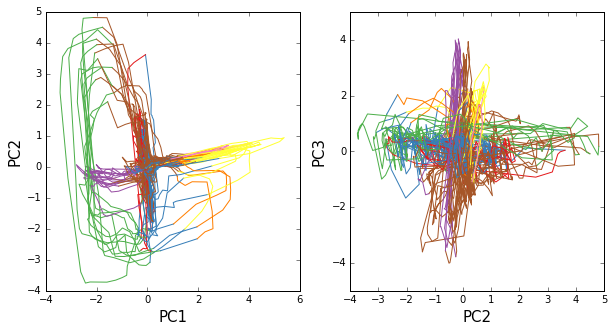

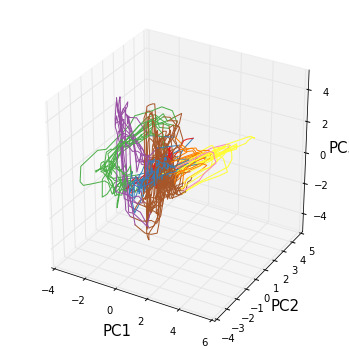

In [4]:
# Try to reproduce their plot of PC's over time
pca = PCA(n_components=10, whiten=True)
pca.fit(dff_deriv)
pca.explained_variance_ratio_

pca_traj = pca.transform(dff_deriv)
pcs = pca.components_.T

plt.figure(figsize=(10,5))
for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    plt.subplot(121)
    plt.plot(pca_traj[cp_start:cp_stop+1,0], 
             pca_traj[cp_start:cp_stop+1,1], 
             '-', color=colors[zimmer_states[cp_start]])
    plt.subplot(122)
    plt.plot(pca_traj[cp_start:cp_stop+1,1], 
             pca_traj[cp_start:cp_stop+1,2], 
             '-', color=colors[zimmer_states[cp_start]])
    
plt.subplot(121)
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)

plt.subplot(122)
plt.xlabel("PC2", fontsize=15)
plt.ylabel("PC3", fontsize=15)

plt.savefig(os.path.join(results_dir, "pca_trajectories.pdf"))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    plt.plot(pca_traj[cp_start:cp_stop+1,0], 
             pca_traj[cp_start:cp_stop+1,1], 
             pca_traj[cp_start:cp_stop+1,2], 
             '-', color=colors[zimmer_states[cp_start]])
ax.set_xlabel("PC1", fontsize=15)
ax.set_ylabel("PC2", fontsize=15)
ax.set_zlabel("PC3", fontsize=15)


plt.savefig(os.path.join(results_dir, "pca_trajectories_3d.pdf"))

In [5]:
# Helper function to get empirical hyperparameters to initialize the SLDS
def _get_empirical_ar_params(train_datas, params, affine=True):
    """
    Estimate the parameters of an AR observation model
    by fitting a single AR model to the entire dataset.
    """
    from pybasicbayes.distributions import Regression

    assert isinstance(train_datas, list) and len(train_datas) > 0
    datadimension = train_datas[0].shape[1]
    assert params["nu_0"] > datadimension + 1

    if affine:
        xs = [np.hstack((td[:-1], np.ones((td.shape[0]-1,1)))) 
             for td in train_datas]
    else:
        xs = [td[:-1]for td in train_datas]

    ys = [td[1:]for td in train_datas]
        
    # Initialize the observation parameters
    obs_params = dict(nu_0=params["nu_0"],
                      S_0=params['S_0'],
                      M_0=params['M_0'],
                      K_0=params['K_0'],
                      affine=False)
    
    # Fit an AR model to the entire dataset
    obs_distn = Regression(**obs_params)
    obs_distn.max_likelihood(zip(xs,ys))

    # Use the inferred noise covariance as the prior mean
    # E_{IW}[S] = S_0 / (nu_0 - datadimension - 1)
    obs_params["S_0"] = obs_distn.sigma * (params["nu_0"] - datadimension - 1)

    return obs_params




In [6]:
# Now try fitting an SLDS to the calcium data

from pyhsmm.basic.distributions import Regression, Gaussian
from autoregressive.distributions import AutoRegression
from pyhsmm.util.text import progprint_xrange

import pyslds.models
reload(pyslds.models)
from pyslds.models import WeakLimitStickyHDPHMMSLDS, HMMSLDS

data = dff_deriv

Nmax = 15          # number of latent discrete states
P = 3              # latent linear dynamics' dimension
P_in = 0           # number of input dimensions
T = data.shape[0]  # number of time bins
D = data.shape[1]  # number of neurons

dynamics_hypparams = dict(nu_0=P+2, S_0=np.eye(P), M_0=np.zeros((P,P+P_in)), K_0=np.eye(P+P_in))
dynamics_hypparams = _get_empirical_ar_params([pca_traj[:,:P]], dynamics_hypparams,
                                             affine=P_in > 0)
dynamics_distns = [
    AutoRegression(
        A=np.hstack((0.99*np.eye(P), np.zeros((P,P_in)))), 
        sigma=np.eye(P),
        **dynamics_hypparams)
    for _ in xrange(Nmax)]

emission_distn = \
    Regression(
        A=np.hstack((pcs[:,:P], np.zeros((D,P_in)))), 
        sigma=np.eye(D),
        nu_0=D+3, S_0=np.eye(D), M_0=np.zeros((D,P+P_in)), K_0=np.eye(P+P_in))

init_dynamics_distns = [
    Gaussian(nu_0=P+2, sigma_0=3.*np.eye(P), mu_0=np.zeros(P), kappa_0=0.01)
    for _ in xrange(Nmax)]

# Sticky HDP-HMM over discrete states
model = WeakLimitStickyHDPHMMSLDS(
    dynamics_distns=dynamics_distns,
    emission_distns=emission_distn,
    init_dynamics_distns=init_dynamics_distns,
    kappa=100.,alpha=3.,gamma=3.,init_state_distn='uniform')


# Add the data and initialize the Gaussian stateseq with the PCA trajectories
inputs = np.ones((T,P_in))

if P_in > 0:
    model.add_data(data, inputs=inputs)
else:
    model.add_data(data)
    
model.states_list[0].gaussian_states = pca_traj[:,:P]
model.states_list[0].resample_discrete_states()
model.resample_parameters()



/Users/scottlinderman/Projects/pybasicbayes/pybasicbayes/util/stats.py:191: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


In [ ]:
# Initialize with non-affine fit
do_initialization = False
if do_initialization:
    init_results_fname = os.path.join("results", "2016_06_30_samples.pkl")
    if os.path.exists(init_results_fname):
        # Check for existing results
        with open(init_results_fname, "r") as f:
            init_model, _, _, _, init_lls = cPickle.load(f)

    assert len(init_model.dynamics_distns) == Nmax
    for dd, init_dd in zip(model.dynamics_distns, init_model.dynamics_distns):
        dd.A[:,:P] = init_dd.A[:,:P]
        dd.A[:,P:] = 0
        dd.sigma = init_dd.sigma.copy()

    for dd, init_dd in zip(model.emission_distns, init_model.emission_distns):
        dd.A[:,:P] = init_dd.A[:,:P]
        dd.A[:,P:] = 0
        dd.sigma = init_dd.sigma.copy()

    model.states_list[0].stateseq = init_model.states_list[0].stateseq.copy()
    model.states_list[0].gaussian_states = init_model.states_list[0].gaussian_states.copy()
    model.trans_distn.trans_matrix = init_model.trans_distn.trans_matrix.copy()

In [ ]:
import cPickle
results_fname = os.path.join(results_dir, "noinput_K%d_samples.pkl" % Nmax)
if os.path.exists(results_fname):
    # Check for existing results
    with open(results_fname, "r") as f:
        model, stateseq_smpls, xs_smpls, sigma_xs_smpls, lls = cPickle.load(f)
        N_samples = len(stateseq_smpls)
else:
    # Fit the model with MCMC
    lls = []
    stateseq_smpls = []
    xs_smpls = []
    sigma_xs_smpls =[]
    N_samples = 1000
    for itr in progprint_xrange(N_samples):
        model.resample_model()
        lls.append(model.log_likelihood())
        stateseq_smpls.append(model.stateseqs[0].copy())
        
        # Get the smoothed continuous states
        model.states_list[0].info_E_step()
        xs = model.states_list[0].smoothed_mus
        sigma_xs = model.states_list[0].smoothed_sigmas
        xs_smpls.append(xs)
        sigma_xs_smpls.append(sigma_xs)
    
    
    results = (model, stateseq_smpls, xs_smpls, sigma_xs_smpls, lls)
    with open(results_fname, "w") as f:
        cPickle.dump(results, f, protocol=-1)



In [ ]:
# Plot the log likelihood vs iteration. 
# Clearly we haven't burned in but al
# ready we see some reasonable states.
print lls[-1]
plt.figure()
plt.plot(lls)
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.show()

In [ ]:
# Helper functions to relabel state sequence by usage
def _get_labelset(labelss):
    import operator
    if isinstance(labelss,np.ndarray):
        labelset = np.unique(labelss)
        return set(labelset[~np.isnan(labelset)])
    else:
        return reduce(operator.or_,(_get_labelset(l) for l in labelss))

def _get_N(labelss):
    return int(max(_get_labelset(labelss)))+1

def relabel_by_permutation(l, perm):
    out = np.empty_like(l)
    good = ~np.isnan(l)
    out[good] = perm[l[good].astype('int32')]
    if np.isnan(l).any():
        out[~good] = np.nan
    return out

def relabel_by_usage(labelss, return_mapping=False, N=None):
    if isinstance(labelss,np.ndarray):
        backwards_compat = True
        labelss = [labelss]
    else:
        backwards_compat = False

    N = _get_N(labelss) if not N else N
    usages = sum(np.bincount(l[~np.isnan(l)].astype('int32'),minlength=N)
                 for l in labelss)
    perm = np.argsort(np.argsort(usages)[::-1])
    outs = [relabel_by_permutation(l,perm) for l in labelss]

    if backwards_compat:
        if return_mapping:
            return outs[0], perm
        else:
            return outs[0]
    else:
        if return_mapping:
            return outs, perm
        else:
            return outs

perm_stateseq_smpls, newlabels = relabel_by_usage(stateseq_smpls, return_mapping=True)
perm_dynamics_distns = [dynamics_distns[i] for i in np.argsort(newlabels)]


In [ ]:
np.unique(np.concatenate(perm_stateseq_smpls))
# np.unique(perm_stateseq_smpls[-1])
N_used = np.concatenate(perm_stateseq_smpls).max()
N_used = max(N_used, len(colors)-1)
N_used = 8

In [ ]:
# Plot the true and inferred state sequences
plt_slice = (0, 3000)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(7,1)

ax3 = fig.add_subplot(gs[-1])
ax1 = fig.add_subplot(gs[:-2])
ax2 = fig.add_subplot(gs[-2])

im = ax1.matshow(perm_stateseq_smpls, aspect='auto', cmap=cmap, vmin=0, vmax=N_used)
ax1.autoscale(False)
ax1.set_xticks([])
ax1.set_yticks([0, N_samples])
ax1.set_ylabel("Iteration")
ax1.set_xlim(plt_slice)
ax1.set_xticks(plt_slice)

ax2.matshow(perm_stateseq_smpls[-1][None,:], aspect='auto', cmap=cmap, vmin=0, vmax=N_used)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Final")
ax2.set_xlim(plt_slice)

ax3.matshow(zimmer_states[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel("Manual")
ax3.set_xlabel("Labels per time bin")
ax3.set_xlim(plt_slice)

plt.savefig(os.path.join(results_dir, "discrete_state_samples.pdf"))

In [ ]:
# Make a legend
if False:
    fig = plt.figure(figsize=(10,2))
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y',which='both', left='off', right='off', labelleft='off')

    handles = []
    for i,name in enumerate(zimmer_key):
        handles.append(ax.bar(0,0, color=cmap(float(i)/(len(colors)-1)), label=name)[0])

    fig = plt.figure(figsize=(10,2))

    plt.figlegend(handles,
                  zimmer_key,
                  loc='center',
                  fontsize=15,
                  ncol=4,
                  title="True Labels")

    # Set the figure background to transparent
    fig.patch.set_alpha(0.0)
    # plt.legend(ncol=4, title="True labels")

    plt.savefig(os.path.join(results_dir, "discrete_state_samples_legend.pdf"))

In [ ]:
# View 1D state trajectories
states = model.states_list[0]
zs = perm_stateseq_smpls[-1]
xs, sigma_xs = xs_smpls[-1], sigma_xs_smpls[-1]
cps = np.concatenate(([0], 1+np.where(np.diff(zs))[0], [zs.size-1]))

plt.figure(figsize=(10,5))
ax2 = plt.subplot(211)
ax2.matshow(perm_stateseq_smpls[-1][None,:], aspect='auto', cmap=cmap, vmin=0, vmax=N_used)
# ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_ylabel("Inferred", fontsize=15)
ax2.set_xlim(plt_slice)

ax2 = plt.subplot(212)
ax2.matshow(zimmer_states[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
# ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Kato et. al.", fontsize=15)
ax2.set_xlim(plt_slice)
ax2.set_xlabel("time", fontsize=15)

plt.savefig(os.path.join(results_dir, "discrete_states_vs_time_comparison.pdf"))

In [ ]:
# Plot one continuous latent state at a time
for xi in range(2):
    plt.figure(figsize=(10,5))

    # Inferred states
    ax1 = plt.subplot(211)
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax1.plot(np.arange(cp_start, cp_stop+1),
                 xs[cp_start:cp_stop+1,xi], 
                 '-', lw=3,
                 color=cmap(zs[cp_start] / float(N_used)))
        
    ax1.set_xlim(0,zs.size)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel("$x_%d$" % (xi+1), fontsize=15)
    ax1.set_title("Inferred labels", fontsize=15)

    # Zimmer states
    ax2 = plt.subplot(212)
    for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
        plt.subplot(212)
        plt.plot(np.arange(cp_start,cp_stop+1), 
                 xs[cp_start:cp_stop+1,xi], 
                 '-', lw=3,
                 color=colors[zimmer_states[cp_start]])
        
    ax2.set_xlim(0,zs.size)
    ax2.set_yticks([])
    ax2.set_xlabel("Frame", fontsize=15)
    ax2.set_ylabel("$x_%d$" % (xi+1), fontsize=15)
    ax2.set_title("Kato et. al.", fontsize=15)

    ax1.set_xlim(plt_slice)
    ax2.set_xlim(plt_slice)
    
    plt.savefig(os.path.join(results_dir, "continuous_states_vs_time_comparison_%d.pdf" % xi))

In [ ]:
# Visualize the manual-inferred state overlap
N_zimmer = len(zimmer_key)
overlap = np.zeros((N_zimmer, N_used+1))
inf_states1 = perm_stateseq_smpls[-1]
for z in range(N_zimmer):
    overlap[z] = np.bincount(inf_states1[zimmer_states==z], minlength=N_used+1)

normalized_overlap = overlap / (1e-3+overlap.sum(1, keepdims=True))

plt.matshow(overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Overlap")

plt.matshow(normalized_overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Normalized Overlap")

In [ ]:
# Plot the inferred latent state sequence
fig = plt.figure(figsize=(10,10))

# Color denotes our inferred latent discrete state
for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
    # x2 vs x1
    plt.subplot(221)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,1], 
             '-', color=cmap(zs[cp_start] / float(N_used)))
    
    # x3 vs x1
    plt.subplot(223)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,2], 
             '-', color=cmap(zs[cp_start] / float(N_used)))

# Color denotes Zimmer state
for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    # x2 vs x1
    plt.subplot(222)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,1], 
             '-', color=colors[zimmer_states[cp_start]])
    

    # x3 vs x1
    plt.subplot(224)
    plt.plot(xs[cp_start:cp_stop+1,0], 
             xs[cp_start:cp_stop+1,2], 
             '-', color=colors[zimmer_states[cp_start]])
    
plt.subplot(221)
plt.title("Inferred", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)

plt.subplot(222)
plt.title("Kato et. al.", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_3$", fontsize=15)

plt.subplot(223)
plt.title("Inferred", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_3$", fontsize=15)

plt.subplot(224)
plt.title("Kato et. al.", fontsize=15)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_3$", fontsize=15)

fig.suptitle("Inferred Continuous Latent State Trajectories", fontsize=15)

plt.savefig(os.path.join(results_dir, "smoothed_trajectories.pdf"))

In [ ]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
# Sum over time bins and smoothed continuous latent states.
# so that each point in continuous latent space is 
#    E_{z} E_x_t [A x_{t} + b]
#
# We would ideally sample over A as well, but to start, just take
# a single sample of A.
from scipy.stats import multivariate_normal
dds = perm_dynamics_distns
n_pts = 50

xmin, xmax = -5, 5
dx = dy = (xmax - xmin) / float(n_pts) 

def plot_vector_field(ax, kk, inds=(0,1), thrpct=0.05, title="", 
                      alpha_max=1.0, alpha_offset=-3):

    t_kk = np.where(zs == kk)[0]
    if len(t_kk) == 0:
        return
    
    # Make a grid for the two dimensions of interest    
    omitted = list(set(range(P)) - set(inds))[0]
    if omitted == 0:
        XX, YY, ZZ = np.meshgrid(
            np.linspace(0,1,1),
            np.linspace(xmin,xmax,n_pts),
            np.linspace(xmin,xmax,n_pts)
        )
    elif omitted == 1:
        XX, YY, ZZ = np.meshgrid(
            np.linspace(xmin,xmax,n_pts),
            np.linspace(0,1,1),
            np.linspace(xmin,xmax,n_pts)
        )
    else:
        XX, YY, ZZ = np.meshgrid(
            np.linspace(xmin,xmax,n_pts),
            np.linspace(xmin,xmax,n_pts),
            np.linspace(0,1,1),
        )

    xx, yy, zz = np.ravel(XX), np.ravel(YY), np.ravel(ZZ)
    xyz = np.column_stack((xx, yy, zz))

    # Figure out where the dynamics take each point
    A = dds[kk].A[:,:P]
    if P_in > 0:
        b = dds[kk].A[:,P:]
    else:
        b = 0
    d_xyz = xyz.dot(A.T) + b - xyz

    
    pr = np.zeros(n_pts**2)
    UU, VV = np.zeros(n_pts**2), np.zeros(n_pts**2)
    for t in t_kk:
        pr_t = multivariate_normal.pdf(
            xyz[:,inds], mean=xs[t][np.ix_(inds)], 
            cov=sigma_xs[t][np.ix_(inds, inds)])
        UU += d_xyz[:,inds[0]]
        VV += d_xyz[:,inds[1]]
        pr += pr_t * dx * dy

    UU /= len(t_kk)
    VV /= len(t_kk)
    pr_t /= len(t_kk)

    UU = UU.reshape((n_pts, n_pts))
    VV = VV.reshape((n_pts, n_pts))

    # Make the plot
    XYZ = map(np.squeeze, [XX, YY, ZZ])
    C = np.ones((n_pts**2, 1)) * np.array(cmap(kk / float(N_used)))[None, :]
    
    logistic = lambda x: 1./(1+np.exp(-x))
    pr_to_alpha = lambda pr: alpha_max * logistic( (pr - pr.mean()) / pr.std() + alpha_offset)
    C[:, -1] = pr_to_alpha(pr)
    
    ax.quiver(XYZ[inds[0]], XYZ[inds[1]], UU, VV, color=C,
                 scale=0.5, scale_units="inches",
                 headwidth=5.,
             )


    ax.set_xlabel("$x_%d$" % (inds[0]+1), fontsize=15)
    ax.set_ylabel("$x_%d$" % (inds[1]+1), fontsize=15)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    
    ax.set_title(title, fontsize=15)

    

In [ ]:
# Plot the individual vector fields
for kk in range(0,7):
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(121)
    plot_vector_field(ax1, kk, inds=(0,1), 
                     title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1))
    ax2 = plt.subplot(122)
    plot_vector_field(ax2, kk, inds=(0,2),
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1))

    plt.savefig(os.path.join(results_dir, "vector_field_{}.pdf".format(kk)))

In [ ]:
# Plot the overlap of each field
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
    
for ktoplot in range(0,7):
    plot_vector_field(ax1, ktoplot, inds=(0,1), alpha_max=0.95, alpha_offset=-4)
    plot_vector_field(ax2, ktoplot, inds=(0,2), alpha_max=0.95, alpha_offset=-4)

ax1.set_title("")
ax2.set_title("")
plt.suptitle("Overlapping Vector Fields of All States")
plt.savefig(os.path.join(results_dir, "vector_field_all.pdf"))